## Installing and importing libraries

In [ ]:
!pip install einops

In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import einops 


import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

## Helper functions: get_seed_images, augment

In [ ]:
def get_seed_images(k=1, n_classes=10):
  class_list = []
  final_classes = []
  mean = 0.2859;  std = 0.3530
  train_set = torchvision.datasets.FashionMNIST(root="./", download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]))
  for _ in range(k):
    for i in range(n_classes):
      class_list.append(i)
  dataloader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=1)
  rand_images = torch.zeros(k * n_classes, 1, 28, 28)

  j=0
  for images, targets in dataloader:
    for i in range(images.shape[0]):
      if targets[i] in class_list:
        rand_images[j] = images[i]
        j += 1
        class_list.remove(targets[i])
        final_classes.append(targets[i].item())

        if class_list == []:
          break

  return rand_images, final_classes

def augment(device, imgs):
  
  mask = imgs.le(-0.8)
  random_patch = torch.rand(imgs.shape[0], 1, 28, 28).to(device)
  random_patch[mask] = imgs[mask] 

  random_grid = torch.rand(imgs.shape[0], 1, 39, 39).to(device)

  new_x = np.random.randint(0, 12)
  new_y = np.random.randint(0, 12)

  random_grid[:,:,new_x:new_x+28,new_y:new_y+28] = imgs 

  return random_grid

class Augmented_Dataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):

        self.images = images
        self.labels = labels

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      image = self.images[idx]
      label = self.labels[idx]

      return image, label

## Experiments with dataset size

In [ ]:
dataset_sizes = [50, 100, 150, 200, 300, 400]

### Modified LeNet

In [ ]:
class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.batchN1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*6*6, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        
        # hidden conv layer 
        t = self.conv1(t) 
        t = F.max_pool2d(input=t, kernel_size=2, stride=2) 
        t = F.relu(t)
        
        # hidden conv layer
        t = self.conv2(t) 
        t = F.max_pool2d(input=t, kernel_size=2, stride=2) 
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*6*6)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t

In [ ]:
experiment_1_all_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_images, classes = get_seed_images(k=2) #get_seed_images().to(device)
seed_images = seed_images.to(device)
print("Seed images collected!")
for n in dataset_sizes:  
  
  accuracies = []

  for j in range(5):
    accuracy_epoch = []
    print(f"n = {n}")

    n = n                              #6000 - size of FashionMNIST
    n_classes = 10

    max_accuracy = 0

    dataset_images = torch.zeros(n*n_classes,1,39,39) 
    dataset_labels = einops.repeat(torch.tensor(classes), 'n -> (repeat n)', repeat=n//2)

    for i in range(n//2):
      new_images = augment(device, seed_images)
      dataset_images[10*2*i:10*2*i+10*2] = new_images

    dataset = Augmented_Dataset(dataset_images, dataset_labels)

    train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                                test_size=0.1,
                                                random_state=999,
                                                shuffle=True,
                                                stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    validation_dataset = Subset(dataset, validation_idx)

    cnn_model = Network().to(device) # init model

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True, num_workers=1)
    test_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=1)

    optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
    # def train loop
    def get_item(preds, labels):
        """function that returns the accuracy of our architecture"""
        return preds.argmax(dim=1).eq(labels).sum().item()

    for epoch in range(10):
        start_time = time.time()
        total_correct = 0
        total_loss = 0
        for batch in train_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs) # get preds
            loss = F.cross_entropy(preds, lbls) # compute loss
            optimizer.zero_grad() # zero grads
            loss.backward() # calculates gradients 
            optimizer.step() # update the weights
            total_loss += loss.item()
        
        for batch in test_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs)
            total_correct += get_item(preds, lbls)
            accuracy = total_correct/len(validation_dataset)

        accuracy_epoch.append(accuracy)
        end_time = time.time() - start_time    
        print("Epoch no.",epoch+1 ,"|test accuracy: ", round(accuracy*100, 3),"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")
    
    accuracies.append(accuracy_epoch)

  experiment_1_all_accuracies.append(accuracies)

100%|██████████| 26421880/26421880 [00:02<00:00, 11005314.90it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202868.93it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3714786.67it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14880962.78it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Seed images collected!
n = 50
Epoch no. 1 |test accuracy:  24.0 % |total_loss:  11.36889934539795 | epoch_duration:  0.42 sec
Epoch no. 2 |test accuracy:  32.0 % |total_loss:  9.366144895553589 | epoch_duration:  0.26 sec
Epoch no. 3 |test accuracy:  46.0 % |total_loss:  7.0105836391448975 | epoch_duration:  0.26 sec
Epoch no. 4 |test accuracy:  52.0 % |total_loss:  6.147669076919556 | epoch_duration:  0.27 sec
Epoch no. 5 |test accuracy:  58.0 % |total_loss:  4.63974666595459 | epoch_duration:  0.28 sec
Epoch no. 6 |test accuracy:  68.0 % |total_loss:  3.812005043029785 | epoch_duration:  0.27 sec
Epoch no. 7 |test accuracy:  76.0 % |total_loss:  3.0992838740348816 | epoch_duration:  0.27 sec
Epoch no. 8 |test accuracy:  82.0 % |total_loss:  2.3485935032367706 | epoch_duration:  0.28 sec
Epoch no. 9 |test accuracy:  82.0 % |total_loss:  1.9201108515262604 | epoch_duration:  0.27 sec
Epoch no. 10 |test accur

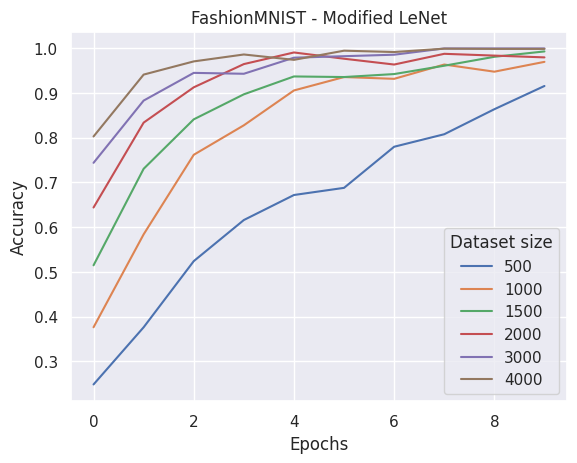

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

epochs = [i for i in range(10)]
 
for i in range(len(dataset_sizes)):
  plt.plot(epochs, np.mean(np.asarray(experiment_1_all_accuracies)[i,:,:], axis=0), label=str(dataset_sizes[i]*10))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FashionMNIST - Modified LeNet")
plt.legend(title="Dataset size")

### Simple Convnet

In [ ]:
class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.fc = nn.Linear(in_features=6*35*35, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        
        # hidden conv layer 
        t = self.conv1(t) 
        t = F.relu(t)
        
        t = t.reshape(-1, 6*35*35)
        t = self.fc(t)
        
        return t

In [ ]:
experiment_2_all_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_images, classes = get_seed_images(k=2) #get_seed_images().to(device)
seed_images = seed_images.to(device)
print("Seed images collected!")
for n in dataset_sizes:  
  
  accuracies = []

  for j in range(5):
    accuracy_epoch = []
    print(f"n = {n}")

    n = n                              #6000 - size of FashionMNIST
    n_classes = 10

    max_accuracy = 0

    dataset_images = torch.zeros(n*n_classes,1,39,39) 
    dataset_labels = einops.repeat(torch.tensor(classes), 'n -> (repeat n)', repeat=n//2)

    for i in range(n//2):
      new_images = augment(device, seed_images)
      dataset_images[10*2*i:10*2*i+10*2] = new_images

    dataset = Augmented_Dataset(dataset_images, dataset_labels)

    train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                                test_size=0.1,
                                                random_state=999,
                                                shuffle=True,
                                                stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    validation_dataset = Subset(dataset, validation_idx)

    cnn_model = Network().to(device) # init model

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True, num_workers=1)
    test_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=1)

    optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
    # def train loop
    def get_item(preds, labels):
        """function that returns the accuracy of our architecture"""
        return preds.argmax(dim=1).eq(labels).sum().item()

    for epoch in range(10):
        start_time = time.time()
        total_correct = 0
        total_loss = 0
        for batch in train_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs) # get preds
            loss = F.cross_entropy(preds, lbls) # compute loss
            optimizer.zero_grad() # zero grads
            loss.backward() # calculates gradients 
            optimizer.step() # update the weights
            total_loss += loss.item()
        
        for batch in test_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs)
            total_correct += get_item(preds, lbls)
            accuracy = total_correct/len(validation_dataset)

        accuracy_epoch.append(accuracy)
        end_time = time.time() - start_time    
        print("Epoch no.",epoch+1 ,"|test accuracy: ", round(accuracy*100, 3),"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")
    
    accuracies.append(accuracy_epoch)

  experiment_2_all_accuracies.append(accuracies)

Seed images collected!
n = 50
Epoch no. 1 |test accuracy:  34.0 % |total_loss:  41.86642813682556 | epoch_duration:  0.24 sec
Epoch no. 2 |test accuracy:  16.0 % |total_loss:  37.989816665649414 | epoch_duration:  0.24 sec
Epoch no. 3 |test accuracy:  46.0 % |total_loss:  22.33707308769226 | epoch_duration:  0.24 sec
Epoch no. 4 |test accuracy:  58.0 % |total_loss:  10.132609367370605 | epoch_duration:  0.23 sec
Epoch no. 5 |test accuracy:  56.0 % |total_loss:  5.235204875469208 | epoch_duration:  0.23 sec
Epoch no. 6 |test accuracy:  70.0 % |total_loss:  3.098642736673355 | epoch_duration:  0.24 sec
Epoch no. 7 |test accuracy:  64.0 % |total_loss:  2.558253675699234 | epoch_duration:  0.23 sec
Epoch no. 8 |test accuracy:  68.0 % |total_loss:  1.7541873157024384 | epoch_duration:  0.24 sec
Epoch no. 9 |test accuracy:  68.0 % |total_loss:  0.9950295239686966 | epoch_duration:  0.23 sec
Epoch no. 10 |test accuracy:  76.0 % |total_loss:  0.6411466896533966 | epoch_duration:  0.23 sec
n = 

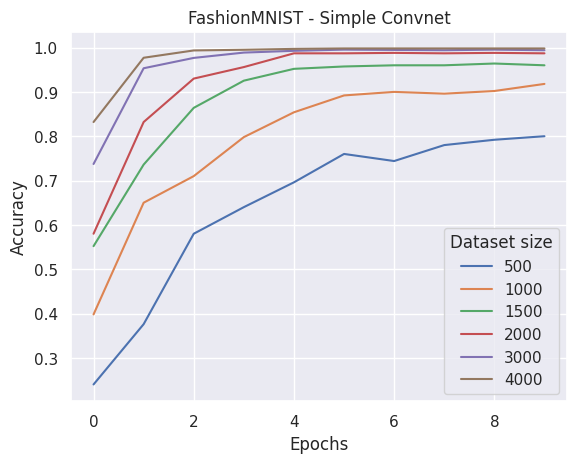

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

epochs = [i for i in range(10)]
 
for i in range(len(dataset_sizes)):
  plt.plot(epochs, np.mean(np.asarray(experiment_2_all_accuracies)[i,:,:], axis=0), label=str(dataset_sizes[i]*10))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FashionMNIST - Simple Convnet")
plt.legend(title="Dataset size")

## Experiments with number of seed images

### Modified LeNet

In [ ]:
class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*6*6, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        
        # hidden conv layer 
        t = self.conv1(t) 
        t = F.max_pool2d(input=t, kernel_size=2, stride=2) 
        t = F.relu(t)
        
        # hidden conv layer
        t = self.conv2(t) 
        t = F.max_pool2d(input=t, kernel_size=2, stride=2) 
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*6*6)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t

In [ ]:
n = 320
k_list = [1, 2, 4, 8, 16, 32]
n_classes = 10

seed_image_experiment_1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:
  
  accuracies = []
  seed_images, classes = get_seed_images(k=k)

  for j in range(5):
    accuracy_epoch = []    
    print(f"Number of seed_images = {k}")
    dataset_images = torch.zeros(n*n_classes,1,39,39) 
    dataset_labels = einops.repeat(torch.tensor(classes), 'n -> (repeat n)', repeat=n//k)

    for i in range(n//k):
      new_images = augment(device, seed_images)
      dataset_images[n_classes*k*i:n_classes*k*i+n_classes*k] = new_images


    dataset = Augmented_Dataset(dataset_images, dataset_labels)

    train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                                test_size=0.1,
                                                random_state=999,
                                                shuffle=True,
                                                stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    validation_dataset = Subset(dataset, validation_idx)

    cnn_model = Network().to(device) # init model

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True, num_workers=1)
    test_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=1)

    optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
    # def train loop
    def get_item(preds, labels):
        """function that returns the accuracy of our architecture"""
        return preds.argmax(dim=1).eq(labels).sum().item()

    for epoch in range(10):
        start_time = time.time()
        total_correct = 0
        total_loss = 0
        for batch in train_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs) # get preds
            loss = F.cross_entropy(preds, lbls) # compute loss
            optimizer.zero_grad() # zero grads
            loss.backward() # calculates gradients 
            optimizer.step() # update the weights
            total_loss += loss.item()
        
        for batch in test_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs)
            total_correct += get_item(preds, lbls)
            accuracy = total_correct/len(validation_dataset)

        accuracy_epoch.append(accuracy)
        end_time = time.time() - start_time    
        print("Epoch no.",epoch+1 ,"|test accuracy: ", round(accuracy*100, 3),"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")

    accuracies.append(accuracy_epoch)
  seed_image_experiment_1.append(accuracies)

Number of seed_images = 1
Epoch no. 1 |test accuracy:  89.062 % |total_loss:  30.419647127389908 | epoch_duration:  1.29 sec
Epoch no. 2 |test accuracy:  100.0 % |total_loss:  3.089426928665489 | epoch_duration:  1.31 sec
Epoch no. 3 |test accuracy:  100.0 % |total_loss:  0.03063204225327354 | epoch_duration:  1.26 sec
Epoch no. 4 |test accuracy:  100.0 % |total_loss:  0.006915073172422126 | epoch_duration:  1.29 sec
Epoch no. 5 |test accuracy:  100.0 % |total_loss:  0.0039109201898099855 | epoch_duration:  1.28 sec
Epoch no. 6 |test accuracy:  100.0 % |total_loss:  0.0029410927381832153 | epoch_duration:  1.27 sec
Epoch no. 7 |test accuracy:  100.0 % |total_loss:  0.0023558967586723156 | epoch_duration:  1.35 sec
Epoch no. 8 |test accuracy:  100.0 % |total_loss:  0.0019384989027457777 | epoch_duration:  2.07 sec
Epoch no. 9 |test accuracy:  100.0 % |total_loss:  0.0016260000556940213 | epoch_duration:  1.48 sec
Epoch no. 10 |test accuracy:  100.0 % |total_loss:  0.0013894283001718577 

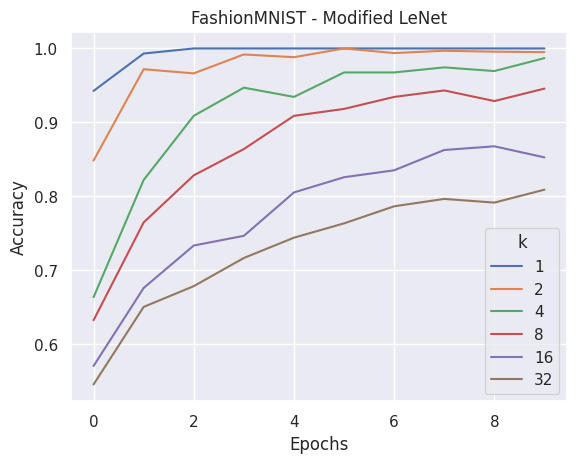

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

epochs = [i for i in range(10)]
 
for i in range(len(k_list)):
  plt.plot(epochs, np.mean(np.asarray(seed_image_experiment_1)[i,:,:], axis=0), label=str(k_list[i]))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FashionMNIST - Modified LeNet")
plt.legend(title = 'k')

### Simple Convnet

In [ ]:
class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.fc = nn.Linear(in_features=6*35*35, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        
        # hidden conv layer 
        t = self.conv1(t) 
        t = F.relu(t)
        
        t = t.reshape(-1, 6*35*35)
        t = self.fc(t)
        
        return t

In [ ]:
n = 320
k_list = [1, 2, 4, 8, 16, 32]
n_classes = 10

seed_image_experiment_2 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:
  
  accuracies = []
  seed_images, classes = get_seed_images(k=k)

  for j in range(5):
    accuracy_epoch = []    
    print(f"Number of seed_images = {k}")
    dataset_images = torch.zeros(n*n_classes,1,39,39) 
    dataset_labels = einops.repeat(torch.tensor(classes), 'n -> (repeat n)', repeat=n//k)

    for i in range(n//k):
      new_images = augment(device, seed_images)
      dataset_images[n_classes*k*i:n_classes*k*i+n_classes*k] = new_images


    dataset = Augmented_Dataset(dataset_images, dataset_labels)

    train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                                test_size=0.1,
                                                random_state=999,
                                                shuffle=True,
                                                stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    validation_dataset = Subset(dataset, validation_idx)

    cnn_model = Network().to(device) # init model

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True, num_workers=1)
    test_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=1)

    optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
    # def train loop
    def get_item(preds, labels):
        """function that returns the accuracy of our architecture"""
        return preds.argmax(dim=1).eq(labels).sum().item()

    for epoch in range(10):
        start_time = time.time()
        total_correct = 0
        total_loss = 0
        for batch in train_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs) # get preds
            loss = F.cross_entropy(preds, lbls) # compute loss
            optimizer.zero_grad() # zero grads
            loss.backward() # calculates gradients 
            optimizer.step() # update the weights
            total_loss += loss.item()
        
        for batch in test_dataloader:
            imgs, lbls = batch
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = cnn_model(imgs)
            total_correct += get_item(preds, lbls)
            accuracy = total_correct/len(validation_dataset)

        accuracy_epoch.append(accuracy)
        end_time = time.time() - start_time    
        print("Epoch no.",epoch+1 ,"|test accuracy: ", round(accuracy*100, 3),"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")

    accuracies.append(accuracy_epoch)
  seed_image_experiment_2.append(accuracies)

Number of seed_images = 1
Epoch no. 1 |test accuracy:  98.75 % |total_loss:  36.75649901479483 | epoch_duration:  0.81 sec
Epoch no. 2 |test accuracy:  100.0 % |total_loss:  0.26505431765690446 | epoch_duration:  0.79 sec
Epoch no. 3 |test accuracy:  100.0 % |total_loss:  0.023583084665006027 | epoch_duration:  0.79 sec
Epoch no. 4 |test accuracy:  100.0 % |total_loss:  0.012297293564188294 | epoch_duration:  0.8 sec
Epoch no. 5 |test accuracy:  100.0 % |total_loss:  0.00924487154406961 | epoch_duration:  0.81 sec
Epoch no. 6 |test accuracy:  100.0 % |total_loss:  0.007432720085489564 | epoch_duration:  0.79 sec
Epoch no. 7 |test accuracy:  100.0 % |total_loss:  0.006225332530448213 | epoch_duration:  0.8 sec
Epoch no. 8 |test accuracy:  100.0 % |total_loss:  0.0052849170242552646 | epoch_duration:  0.88 sec
Epoch no. 9 |test accuracy:  100.0 % |total_loss:  0.004549683399091009 | epoch_duration:  1.46 sec
Epoch no. 10 |test accuracy:  100.0 % |total_loss:  0.003977402055170387 | epoch

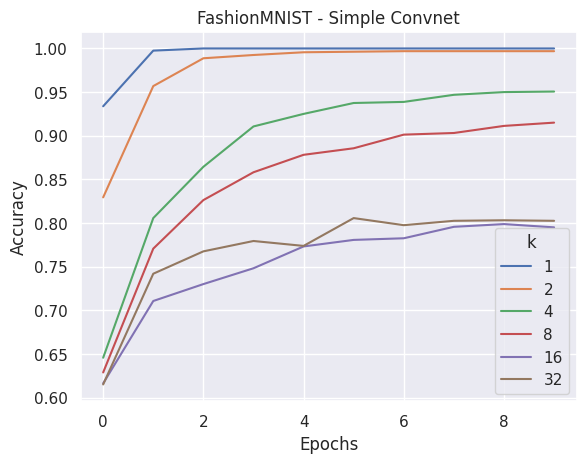

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

epochs = [i for i in range(10)]
 
for i in range(len(k_list)):
  plt.plot(epochs, np.mean(np.asarray(seed_image_experiment_2)[i,:,:], axis=0), label=str(k_list[i]))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FashionMNIST - Simple Convnet")
plt.legend(title = 'k')